<a href="https://colab.research.google.com/github/Garima27dec/Emotion-Detection-with-Multiple-Data-Streams/blob/main/EEG_Brain_Signals_Emotion_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%pip install pyod
import os
import numpy as np
from pyod.models import hbos
from pyod.utils.data import evaluate_print
from sklearn.metrics import confusion_matrix,cohen_kappa_score,f1_score
from scipy import signal
import matplotlib.pyplot as plt
import pickle
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.1.0-py3-none-any.whl size=185329 sha256=b2d297f95e9d5fd2f0dde971dff1342df6a920351541ee2cbac4d3daa42abcfd
  Stored in directory: /root/.cache/pip/wheels/36/8e/e2/e932956b10b843eb6be9eefa70b5c1bee7b561be14c423b136
Successfully built pyod


In [2]:
channels = 32
seconds = 0.5    # Size of each segment we want
fs = 256.0         # Dtaset eeg sampling rate
data_portion = 1
save_model = False

In [3]:
df = pd.read_csv('/content/features_raw.csv')
df.head()

,Fp1,AF3,F3,F7,FC5,FC1,C3,T7,CP5,CP1,...,Cz,C4,T8,CP6,CP2,P4,P8,PO4,O2,Unnamed: 32
0,0.057813,-1.335266,4.640480,0.219573,7.473817,2.314842,1.918097,-9.257533,9.089943,-7.104519,...,-2.241480,1.415335,2.406646,12.864059,4.021099,-2.828598,-2.588735,2.637905,-5.226618,NaN
1,1.367408,10.259654,3.345409,7.897852,-2.446051,-1.655035,-6.301423,-7.290317,-3.546453,-5.705187,...,-2.568397,-5.651418,-0.096730,-4.930759,-1.722504,-6.111309,0.094893,-3.521353,1.887093,NaN
2,-1.783132,4.133553,-0.951680,-1.624803,-1.827309,-2.280364,-2.279225,9.151344,-0.239575,-0.057604,...,-2.132823,-0.521117,8.605298,-4.499946,-3.232839,-4.249645,-3.687167,-7.383004,-4.489537,NaN
3,-3.690217,-0.814000,2.295469,0.901445,8.323679,1.127906,6.356886,11.642082,9.354154,-1.662478,...,-0.506117,-1.154866,-3.940251,7.390881,2.129897,-0.794675,-1.959021,2.774530,-6.323060,NaN
4,2.137114,6.420466,6.122230,10.015321,3.106394,3.183129,3.658535,4.571793,4.917712,-2.325940,...,1.813907,-6.444635,-27.680880,0.641364,1.996658,-0.445779,2.614021,6.161845,3.308816,NaN


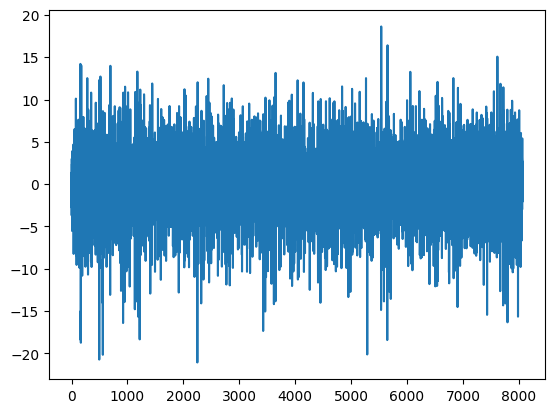

In [4]:
plt.plot(df['Fp1'])

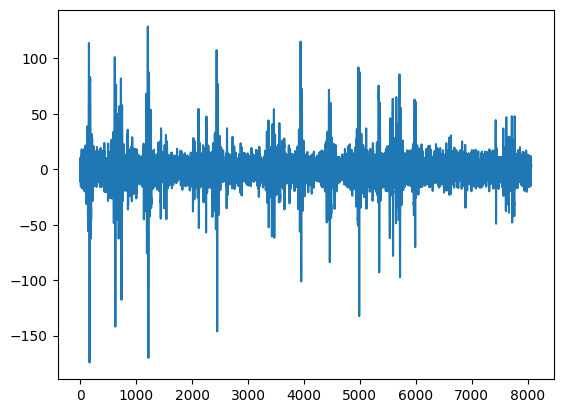

In [5]:
plt.plot(df['AF3'])

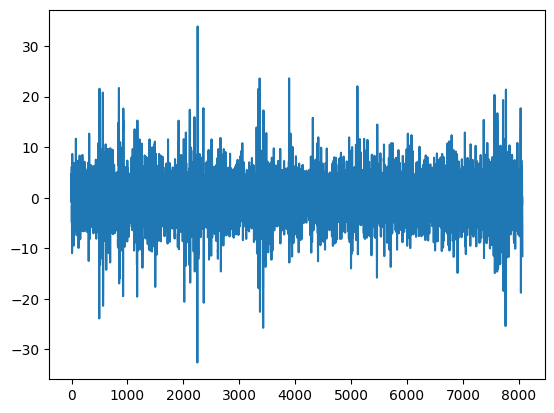

In [6]:
plt.plot(df['F3'])

In [7]:
class EEGDataset2:
    def __init__(self, train_csv, seconds=0.500, fs=256, data_portion=1, normalize=True, isolated_channels=False):
        assert data_portion > 0.0 and data_portion <= 1, 'data_portion should be > 0 and <= 1'

        self.isolated_channels = isolated_channels
        self.normalize = normalize
        self.train_csv = train_csv
        self.seconds = seconds
        self.fs = fs
        self.data_portion = data_portion

    def get_data(self):
        df = pd.read_csv(self.train_csv)
        array_size = int(self.seconds * self.fs)
        # Dataset shape is: [data x channels]
        # we want shape: [segments x features]

        if self.normalize:
            df = (df - df.mean()) / df.std()

        if self.isolated_channels:
            channels = []
            for channel in df.columns[0:32]:
                isolated_channel = []
                for i in range(int(len(df) / array_size)):
                    isolated_channel.append(df[channel][i*array_size:(i+1)*array_size].to_numpy())
                channels.append(np.array(isolated_channel))
            return np.array(channels)

        dataset = []

        for channel in df.columns[0:32]:
            for i in range(int(len(df) / array_size)):
                dataset.append(df[channel][i*array_size:(i+1)*array_size].to_numpy())

        return np.array(dataset)

In [8]:
train_csv = '/content/features_raw.csv'
eegDataset = EEGDataset2(train_csv, seconds, fs, data_portion, normalize=True)

train_dataset = eegDataset.get_data()

In [9]:
train_dataset.shape

(2016, 128)

In [10]:
clf = hbos.HBOS(n_bins=17, alpha=0.07, tol=0.5,contamination=.15)
clf.fit(train_dataset)

print("="*20)
print("TRAINING THE MODEL")

TRAINING THE MODEL


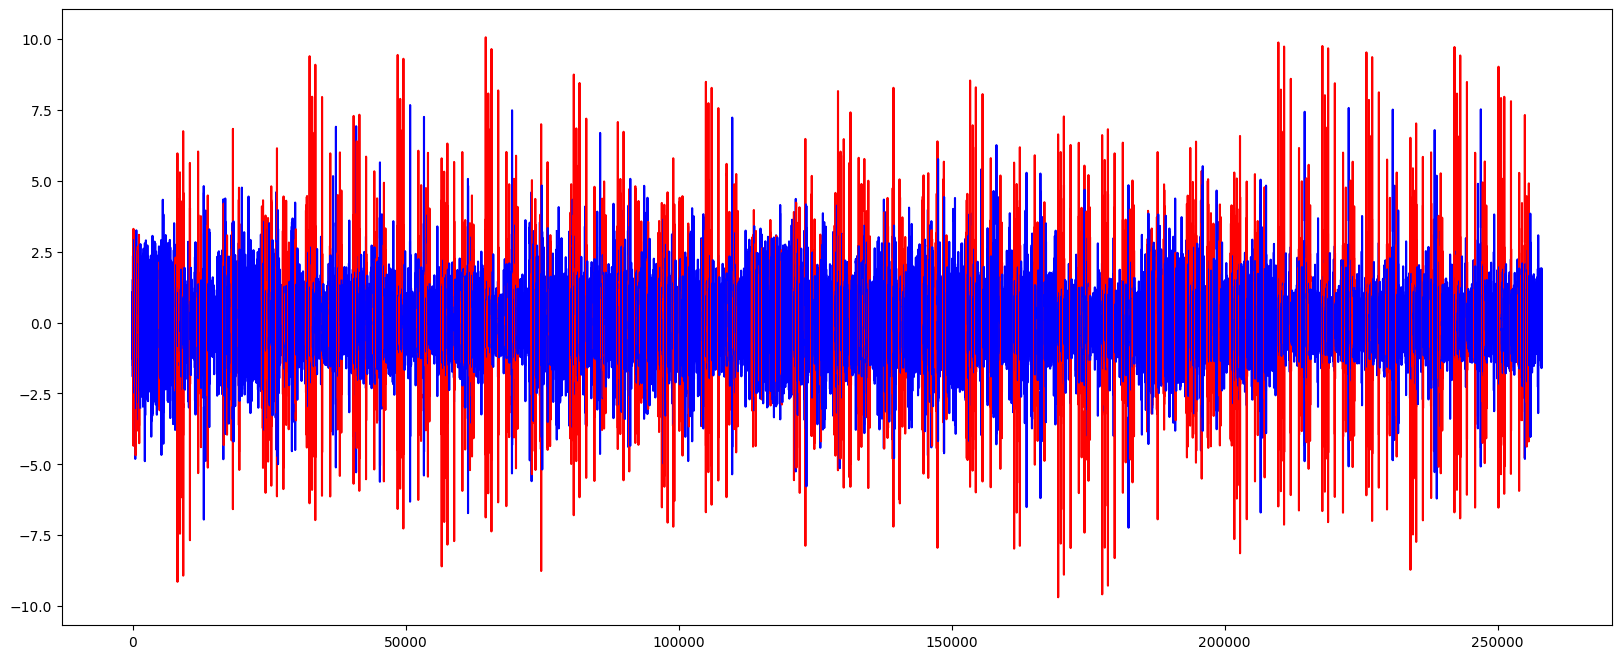

In [11]:
pred = clf.predict(train_dataset)

for i in range(len(pred)):
    plt.rcParams["figure.figsize"] = (20,8)

    if pred[i] == 1: plt.plot(range(128*i,128*(i+1)), train_dataset[i], color='red')
    else: plt.plot(range(128*i,128*(i+1)), train_dataset[i], color='b')

In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
tf.keras.backend.clear_session()
from sklearn.metrics import confusion_matrix
from sklearn import datasets, tree, linear_model, svm
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

In [14]:
data = pd.read_csv("/content/emotions.csv")

In [15]:
len(data)

2132

In [16]:
pos = data.loc[data["label"]=="POSITIVE"]
sample_pos = pos.loc[2, 'fft_0_b':'fft_749_b']
neg = data.loc[data["label"]=="NEGATIVE"]
sample_neg = neg.loc[0, 'fft_0_b':'fft_749_b']
neu = data.loc[data["label"]=="NEUTRAL"]
sample_neu = neu.loc[1, 'fft_0_b':'fft_749_b']

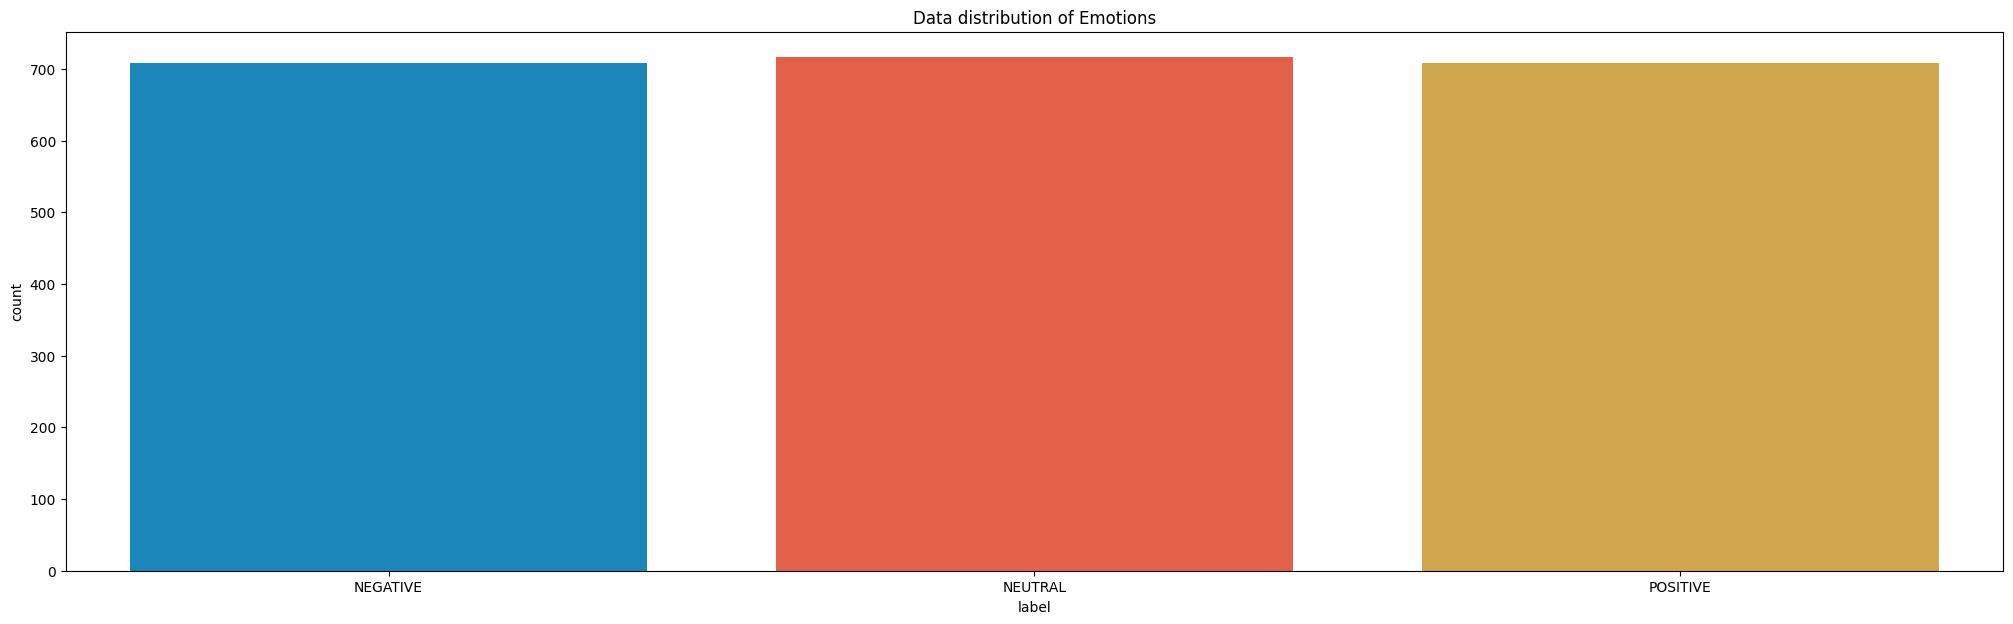

In [17]:
plt.figure(figsize=(25,7))
plt.title("Data distribution of Emotions")
plt.style.use('fivethirtyeight')
sns.countplot(x='label', data=data)
plt.show()

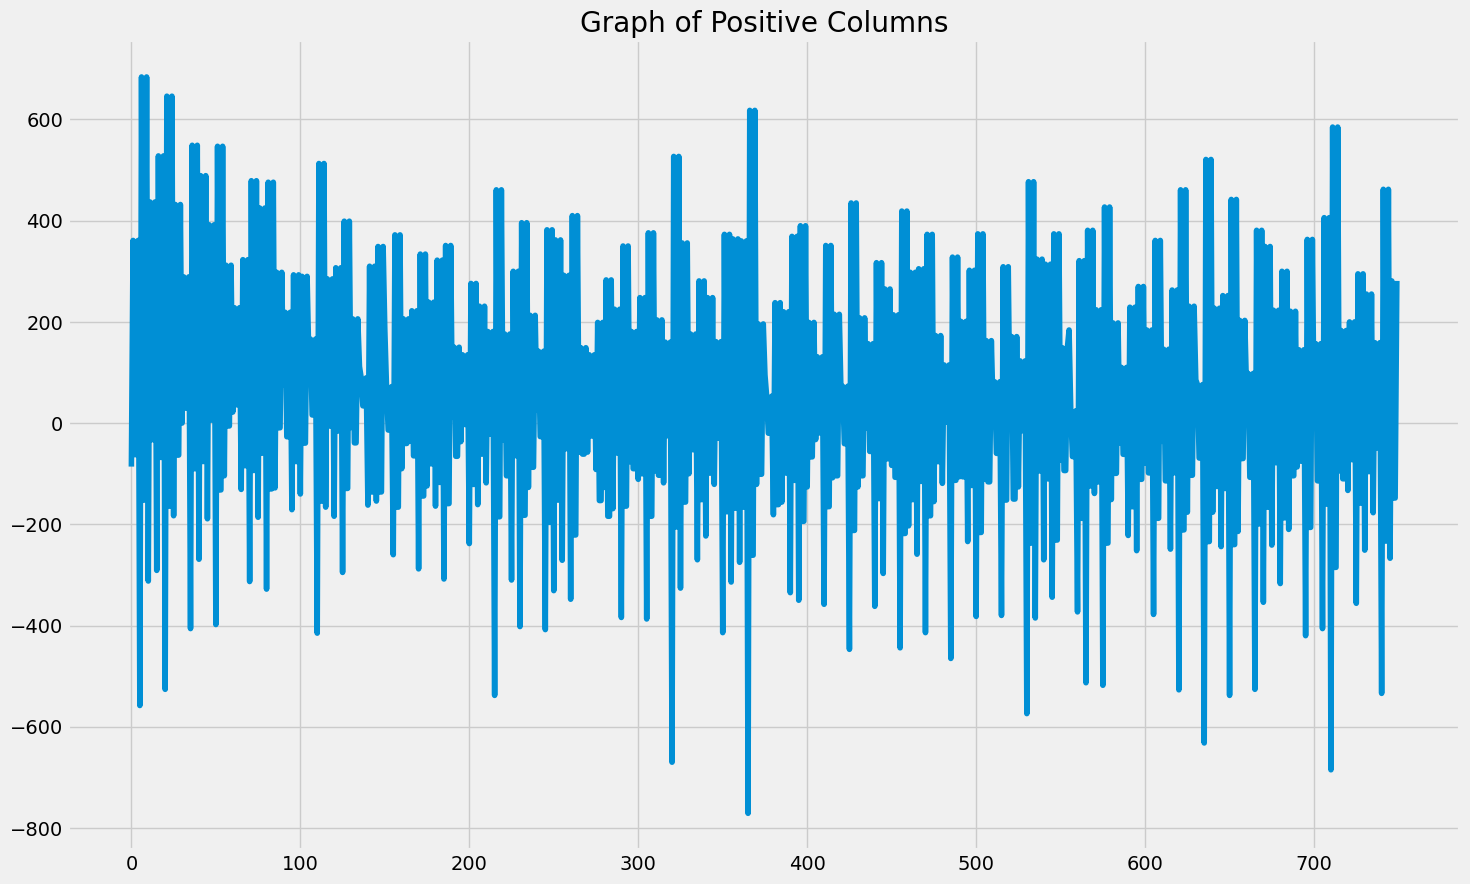

In [18]:
plt.figure(figsize=(16, 10))
plt.plot(range(len(sample_pos)), sample_pos)
plt.title("Graph of Positive Columns")
plt.show()

In [19]:
def Transform_data(data):
    #Encoding Lables into numbers
    encoding_data = ({'NEUTRAL': 0, 'POSITIVE': 1, 'NEGATIVE': 2} )
    data_encoded = data.replace(encoding_data)
    #getting brain signals into x variable
    x=data_encoded.drop(["label"]  ,axis=1)
    #getting labels into y variable
    y = data_encoded.loc[:,'label'].values
    scaler = StandardScaler()
    #scaling Brain Signals
    scaler.fit(x)
    X = scaler.transform(x)
    #One hot encoding Labels
    Y = to_categorical(y)
    return X,Y

In [20]:
X,Y = Transform_data(data)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 4)

In [21]:
x_train.shape[1]

2548

In [22]:
def create_model():
    #input layer of model for brain signals
    inputs = tf.keras.Input(shape=(x_train.shape[1],))
    #Hidden Layer for Brain signal using LSTM(GRU)
    expand_dims = tf.expand_dims(inputs, axis=2)

    gru = tf.keras.layers.GRU(256, return_sequences=True)(expand_dims)
    #Flatten Gru layer into vector form (one Dimensional array)
    flatten = tf.keras.layers.Flatten()(gru)
    #output latyer of Model
    outputs = tf.keras.layers.Dense(3, activation='softmax')(flatten)


    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    print(model.summary())
    return model

In [23]:
lstmmodel = create_model()
#Compiling model
lstmmodel.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2548)]            0         
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 2548, 1)          0         
                                                                 
 gru (GRU)                   (None, 2548, 256)         198912    
                                                                 
 flatten (Flatten)           (None, 652288)            0         
                                                                 
 dense (Dense)               (None, 3)                 1956867   
                                                                 
Total params: 2,155,779
Trainable params: 2,155,779
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
history = lstmmodel.fit(x_train, y_train, epochs = 10, validation_split=0.1)
loss, acc = lstmmodel.evaluate(x_test, y_test)

Epoch 1/10
48/48 [==============================] - 14s 114ms/step - loss: 0.5765 - accuracy: 0.8618 - val_loss: 0.2892 - val_accuracy: 0.9240
Epoch 2/10
48/48 [==============================] - 5s 103ms/step - loss: 0.1880 - accuracy: 0.9263 - val_loss: 0.2520 - val_accuracy: 0.9357
Epoch 3/10
48/48 [==============================] - 5s 102ms/step - loss: 0.1489 - accuracy: 0.9485 - val_loss: 0.2608 - val_accuracy: 0.9298
Epoch 4/10
48/48 [==============================] - 5s 101ms/step - loss: 0.1244 - accuracy: 0.9531 - val_loss: 0.0963 - val_accuracy: 0.9415
Epoch 5/10
48/48 [==============================] - 5s 105ms/step - loss: 0.0707 - accuracy: 0.9713 - val_loss: 0.1036 - val_accuracy: 0.9708
Epoch 6/10
48/48 [==============================] - 5s 102ms/step - loss: 0.0462 - accuracy: 0.9896 - val_loss: 0.1193 - val_accuracy: 0.9591
Epoch 7/10
48/48 [==============================] - 5s 102ms/step - loss: 0.0324 - accuracy: 0.9876 - val_loss: 0.2023 - val_accuracy: 0.9474
Epoch

In [25]:
print(f"Loss on testing: {loss*100}",f"\nAccuracy on Training: {acc*100}")

Loss on testing: 10.469558835029602 
Accuracy on Training: 96.48711681365967


In [34]:
lstmmodel.save('drive/My Drive/Emotion_Recognition/EEG/[LSTM]M.h5')
lstmmodel.save_weights('drive/My Drive/Emotion_Recognition/EEG/[LSTM]W.h5')

In [26]:
pred  = lstmmodel.predict(x_test)

14/14 [==============================] - 1s 56ms/step


In [27]:
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(data.label.unique()))
    plt.xticks(tick_marks, names, rotation=90)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [28]:
pred1 = np.argmax(pred,axis=1)

In [29]:
y_test1 =   np.argmax(y_test,axis=1)

In [30]:
print("Predicted:  ",pred1[:10])
print("\n")
print("Actual: ",y_test1[:10])

Predicted:   [1 1 1 2 1 1 2 1 2 1]


Actual:  [1 1 1 2 1 1 2 1 2 1]


Confusion matrix, without normalization
[[150   3   0]
 [  2 133   7]
 [  0   3 129]]


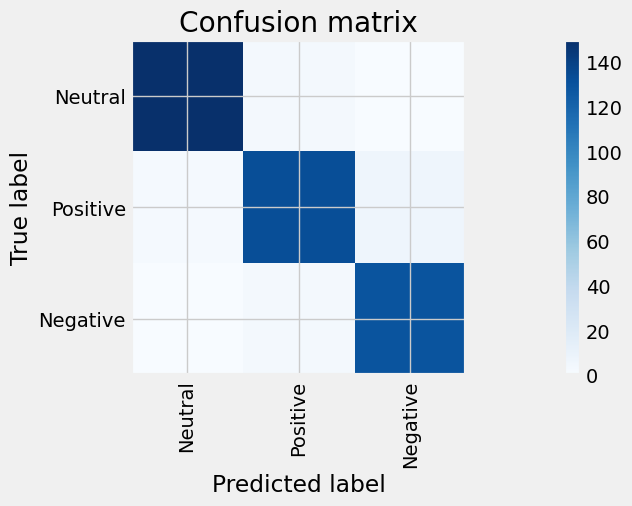

In [31]:
cm = confusion_matrix(y_test1, pred1)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.rcParams["figure.figsize"]=(20,5)
plt.figure()
plot_confusion_matrix(cm,["Neutral","Positive","Negative"])

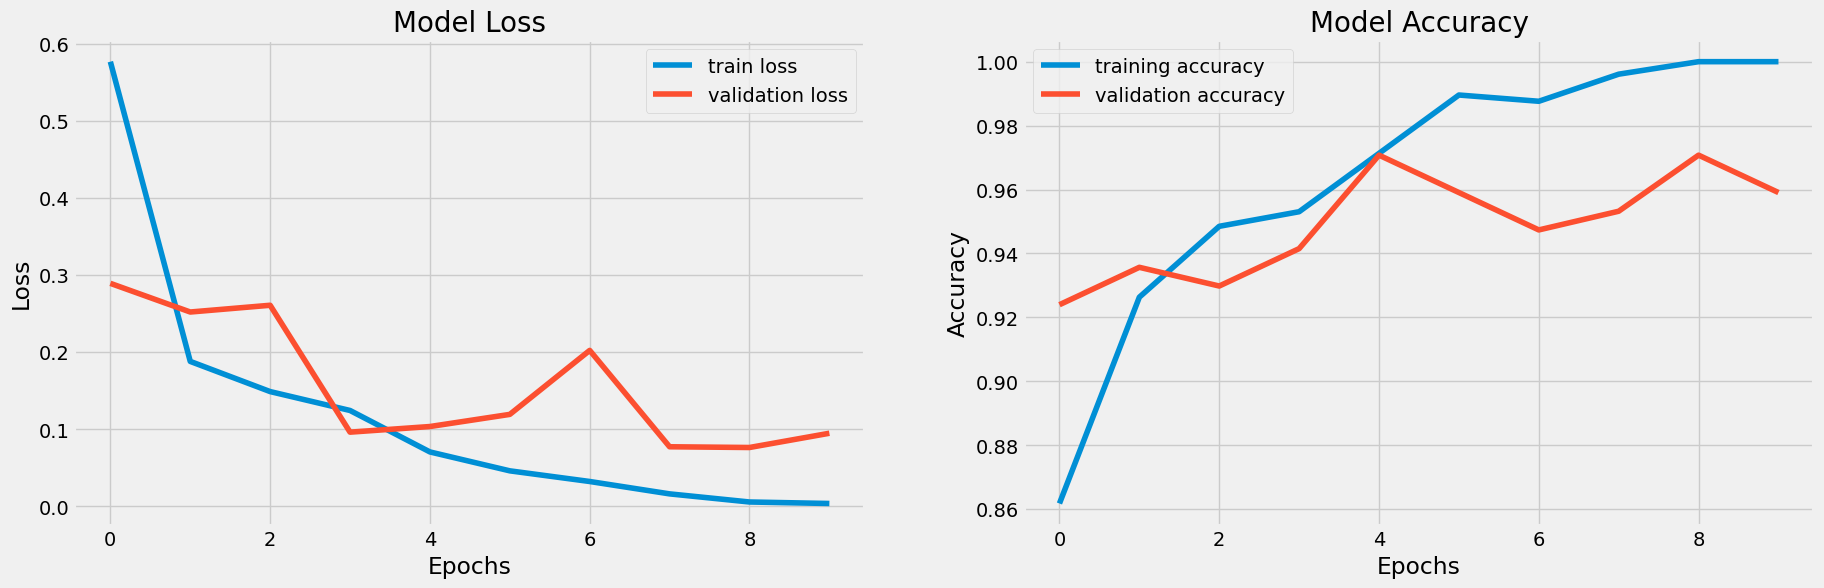

In [32]:
#Plotting Graph of Lstm model Training, Loss and Accuracy
plt.style.use("fivethirtyeight")
plt.figure(figsize = (20,6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss",fontsize=20)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train loss', 'validation loss'], loc ='best')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy",fontsize=20)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['training accuracy', 'validation accuracy'], loc ='best')
plt.show()

In [36]:
#Load model

from keras.models import load_model
model_eeg = load_model('/content/drive/MyDrive/Emotion_Recognition/EEG/[LSTM]M.h5')
model_eeg.load_weights('/content/drive/MyDrive/Emotion_Recognition/EEG/[LSTM]W.h5')
print("Loaded model from disk")

Loaded model from disk
